In [1]:
# import libraries
from ctypes import util
import PIL
from PIL import Image
import numpy as np
import os
from sklearn import utils
import matplotlib.pyplot as plt
import random

In [71]:
# load in the data
dataset_folder = 'Spiral_DataSet1_relabelled'

data_array = []
labels = []
itr = 0

# iterate through all images and combine into one dataset with a mix of both healthy and PD images
# create an array of corresponding labels (1 - PD, 0 - healthy)
for labeled_folder in os.listdir(dataset_folder):
    '''
    if labeled_folder == "healthy":
        healthy = np.zeros(len(os.listdir(dataset_folder + "/" + labeled_folder)), dtype=object)
        itr = 0
    else:
        pd = np.zeros(len(os.listdir(dataset_folder + "/" + labeled_folder)), dtype=object)
        itr = 0
    '''
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        
        image = PIL.Image.open(dataset_folder + "/" + labeled_folder + "/" + img)
        image = image.convert("L")
        #bw_image.show()
        image_array = np.array(image)
        image_array[image_array < 200] = 0    # black
        image_array[image_array >= 200] = 255 # white

        # check length of array to make sure size 256x256, if not, add white pixels onto the end
        img_size = np.size(image_array)
        if img_size == 256**2:

            #imfile = Image.fromarray(image_array)
            #imfile.show(imfile)        

            data_array.append(image_array.flatten().astype(float))
            #data_array[itr] = image_array.flatten().astype(float)

            if labeled_folder == "healthy": 
                labels.append(0)
            else:
                labels.append(1)

            itr = itr+1

        '''
        # break up the data into labelled arrays
        if labeled_folder == "healthy":
            healthy[itr] = image_array.flatten()
        else:
            pd[itr] = image_array.flatten()
        itr = itr + 1
        '''


# Now we have all the images in array form to analyze

#print(np.shape(healthy))
#print(np.size(healthy))
#print(healthy)

In [86]:
# ---------------------------------------------------------------
#            Split into training and validation data
# ---------------------------------------------------------------
data_array, labels = utils.shuffle(np.array(data_array), np.array(labels))

num_trn = round(99 - 99*0.2) 

# split into training and validation data
train_data = data_array[:num_trn] / 255
train_labels = labels[:num_trn]

val_data = np.delete(data_array, np.linspace(0,num_trn, num_trn-1).astype(int), axis=0) / 255
val_labels = np.delete(labels, np.linspace(0,num_trn, num_trn-1).astype(int), axis=0)
print("Validation labels: ", val_labels)

tdata = []
for i in range(len(train_data)):
    tdata.append(np.reshape(train_data[i], (256,256,1)))
vdata = []
for i in range(len(val_data)):
    vdata.append(np.reshape(val_data[i], (256,256,1)))

Validation labels:  [0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0]


## KNN Classification

In [87]:
# --------------------------------------------------------
#                       KNN classification
# --------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier

knnModel = KNeighborsClassifier(n_neighbors=3)
trained_model = knnModel.fit(list(train_data), train_labels.astype(int))

accuracies = []
for k in range(1, 16, 1):
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(list(train_data), train_labels.astype(int))
    # evaluate the model and update the accuracies list
    score = model.score(list(val_data), val_labels.astype(int))
    #print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

0.7142857142857143


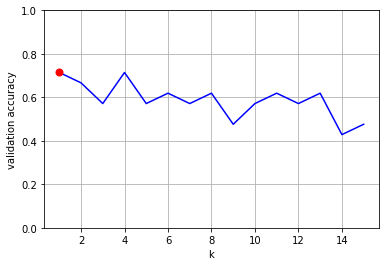

In [88]:
## ----------------------------------
#         Plot the Results
## ----------------------------------
k=np.linspace(1,15,15)
val_accuracy = accuracies
max_acc = np.argmax(val_accuracy)
print(val_accuracy[max_acc])

plt.plot(k, val_accuracy, 'b')
plt.plot(max_acc+1, val_accuracy[max_acc], 'r', marker='o', markersize=7)
plt.ylim([0,1])
plt.xlabel("k")
plt.ylabel("validation accuracy")
plt.grid('on')
plt.show()


## CNN Classification

In [89]:
# --------------------------------------------------------
#                          CNN
# --------------------------------------------------------

from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model

#import tensorflow as tf
#tdata = tf.stack(tdata)
#train_labels = tf.stack(train_labels)
#vdata = tf.stack(vdata)
#val_labels = tf.stack(val_labels)

#from tensorflow.keras.utils import to_categorical
#train_labels = to_categorical(train_labels)
#val_labels = to_categorical(val_labels)

#trained_model = model.fit(tdata, train_labels, epochs=10, validation_data=(vdata, val_labels))
print(val_labels)
trained_model = model.fit(np.array(tdata), np.array(train_labels), epochs=20, validation_data=(np.array(vdata), np.array(val_labels)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 62, 62, 64)       

0.6666666865348816


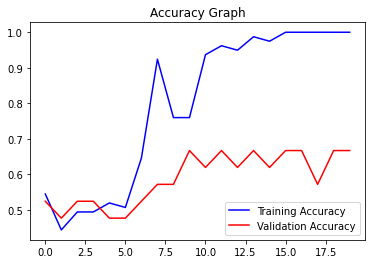

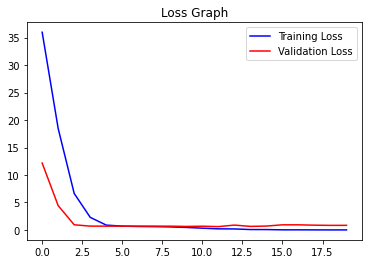

In [90]:
## ----------------------------------
#         Plot the Results
## ----------------------------------
# Accuracy and Validation Accuracy
accuracy = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
epochs = range(len(accuracy))

print(val_acc[np.argmax(val_acc)])

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Loss and Validation Loss
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## SVM

In [100]:
# import SVM library
from sklearn import svm

# create SVM classifier
clf = svm.SVC(kernel='linear', C=5)

# train model
clf.fit(tdata, vdata)

ValueError: Found array with dim 4. Estimator expected <= 2.